# 1. Build CNN

## 1.1 Preparing

In [1]:
import numpy as np
import tensorflow as tf

## 1.2 Data preprocessing

In [5]:
# 导入手写数字数据集
from sklearn.datasets import load_digits

# 数据预处理
digits = load_digits()

X_data = digits.data.astype(np.float32)
Y_data = digits.target.astype(np.float32).reshape(-1,1)
print(X_data.shape)
print(Y_data.shape)

(1797, 64)
(1797, 1)


In [11]:
'''
数据的标准化（normalization）是将数据按比例缩放，
使之落入一个小的特定区间。这样去除数据的单位限制，
将其转化为无量纲的纯数值，便于不同单位或量级的指标能够进行比较和加权。
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)
print('标准化后的数据:\n', X_data)

from sklearn.preprocessing import OneHotEncoder
Y = OneHotEncoder().fit_transform(Y_data).todense()  # one-hot 独热编码
print('\nOne-Hot独热编码:\n', Y)

标准化后的数据:
 [[ 0.      0.      0.3125 ...,  0.      0.      0.    ]
 [ 0.      0.      0.     ...,  0.625   0.      0.    ]
 [ 0.      0.      0.     ...,  1.      0.5625  0.    ]
 ..., 
 [ 0.      0.      0.0625 ...,  0.375   0.      0.    ]
 [ 0.      0.      0.125  ...,  0.75    0.      0.    ]
 [ 0.      0.      0.625  ...,  0.75    0.0625  0.    ]]

One-Hot独热编码:
 [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [12]:
# 转换为图片的格式(batch, height, width, channels)
X = X_data.reshape(-1,8,8,1)

batch_size = 8  # 使用MBGD算法，设定batch_size为8

def generatebatch(X, Y, n_examples, batch_size):
    for batch_i in range(n_examples // batch_size):
        start = batch_i*batch_size
        end = start + batch_size
        batch_xs = X[start:end]
        batch_ys = Y[start:end]
        yield batch_xs, batch_ys  # 生成每一个batch

In [15]:
# 清除默认图的堆栈，并设置全图为默认图
tf.reset_default_graph()

## 1.3 Layer implement

### 输入层

In [24]:
tf_X = tf.placeholder(tf.float32, [None,8,8,1])
tf_Y = tf.placeholder(tf.float32, [None,10])

### 卷积层 conv1 + 激活层

In [25]:
conv_filter_w1 = tf.Variable(tf.random_normal([3,3,1,10]))
conv_filter_b1 = tf.Variable(tf.random_normal([10]))
relu_feature_maps1 = tf.nn.relu(tf.nn.conv2d(tf_X, conv_filter_w1, strides=[1,1,1,1], padding='SAME') + conv_filter_b1)

参数说明：

- data_format：表示输入的格式，有两种分别为：“NHWC”和“NCHW”，默认为“NHWC”

- input：输入是一个4维格式的（图像）数据，数据的 shape 由 data_format 决定：当 data_format 为“NHWC”输入数据的shape表示为[batch, in_height, in_width, in_channels]，分别表示训练时一个batch的图片数量、图片高度、 图片宽度、 图像通道数。当 data_format 为“NCHW”输入数据的shape表示为[batch, in_channels， in_height, in_width]

- filter：卷积核是一个4维格式的数据：shape表示为：[height,width,in_channels, out_channels]，分别表示卷积核的高、宽、深度（与输入的in_channels应相同）、输出 feature map的个数（即卷积核的个数）。

- strides：表示步长：一个长度为4的一维列表，每个元素跟data_format互相对应，表示在data_format每一维上的移动步长。当输入的默认格式为：“NHWC”，则 strides = [batch , in_height , in_width, in_channels]。其中 batch 和 in_channels 要求一定为1，即只能在一个样本的一个通道上的特征图上进行移动，in_height , in_width表示卷积核在特征图的高度和宽度上移动的布长，即 strideheight 和 stridewidth 。

-padding：表示填充方式：“SAME”表示采用填充的方式，简单地理解为以0填充边缘，当stride为1时，输入和输出的维度相同；“VALID”表示采用不填充的方式，多余地进行丢弃。具体公式：

“SAME”: output_spatial_shape[i] = input_spatial_shape[i] / strides[i]
“VALID”: output_spatial_shape[i] = input_spatial_shape[i]−(spatial_filter_shape[i]−1)/strides[i]

### 池化层

In [27]:
max_pool1 = tf.nn.max_pool(relu_feature_maps1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

print(max_pool1)

Tensor("MaxPool_1:0", shape=(?, 4, 4, 10), dtype=float32)


- value：表示池化的输入：一个4维格式的数据，数据的 shape 由 data_format 决定，默认情况下shape 为[batch, height, width, channels]

其他参数与 tf.nn.conv2d 类型

- ksize：表示池化窗口的大小：一个长度为4的一维列表，一般为[1, height, width, 1]，若不想在batch和channels上做池化，则将其值设为1。

### 卷积层 conv2

In [30]:
conv_filter_w2 = tf.Variable(tf.random_normal([3,3,10,5]))
conv_filter_b2 = tf.Variable(tf.random_normal([5]))
conv_out2 = tf.nn.conv2d(relu_feature_maps1, conv_filter_w2, strides=[1,2,2,1], padding='SAME') + conv_filter_b2

print(conv_out2)

Tensor("add_1:0", shape=(?, 4, 4, 5), dtype=float32)


### BN归一化层 + 激活层

In [32]:
batch_mean, batch_var = tf.nn.moments(conv_out2, [0,1,2], keep_dims=True)
shift = tf.Variable(tf.zeros([5]))
scale = tf.Variable(tf.ones([5]))
epsilon = 1e-3
BN_out = tf.nn.batch_normalization(conv_out2, batch_mean, batch_var, shift, scale, epsilon)

print(BN_out)

relu_BN_maps2 = tf.nn.relu(BN_out)

Tensor("batchnorm/add_1:0", shape=(?, 4, 4, 5), dtype=float32)


参数说明：
- mean 和 variance 通过 tf.nn.moments 来进行计算： 
batch_mean, batch_var = tf.nn.moments(x, axes = [0, 1, 2], keep_dims=True)，注意axes的输入。对于以feature map 为维度的全局归一化，若feature map 的shape 为[batch, height, width, depth]，则将axes赋值为[0, 1, 2]

- x 为输入的feature map 四维数据，shift、scale为一维Tensor数据，shape 等于 feature map 的深度depth。


### 池化层

In [33]:
max_pool2 = tf.nn.max_pool(relu_BN_maps2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
print(max_pool2)

Tensor("MaxPool_2:0", shape=(?, 2, 2, 5), dtype=float32)


#### 将特征图进行展开

In [34]:
max_pool2_flat = tf.reshape(max_pool2, [-1, 2*2*5])

### 全连接层

In [35]:
fc_w1 = tf.Variable(tf.random_normal([2*2*5, 50]))
fc_b1 = tf.Variable(tf.random_normal([50]))
fc_out1 = tf.nn.relu(tf.matmul(max_pool2_flat, fc_w1) + fc_b1)

### 输出层

In [36]:
out_w1 = tf.Variable(tf.random_normal([50, 10]))
out_b1 = tf.Variable(tf.random_normal([10]))
pred = tf.nn.softmax(tf.matmul(fc_out1, out_w1) + out_b1)

## 1.4 Start training

In [82]:
%%time

loss = -tf.reduce_mean(tf_Y * tf.log(tf.clip_by_value(pred, 1e-11, 1.0)))

# Adam优化算法：是一个寻找全局最优点的优化算法，引入了二次方梯度校正
# 相比于基础SGD算法，1.不容易陷于局部优点。2.速度更快
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

y_pred = tf.arg_max(pred, 1)
bool_pred = tf.equal(tf.arg_max(tf_Y, 1), y_pred)

accuracy = tf.reduce_mean(tf.cast(bool_pred, tf.float32))  # 准确率

y = np.random.randn(100)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(100):  # 迭代100个周期
        for batch_xs, batch_ys in generatebatch(X, Y, Y.shape[0], batch_size):  # 每个周期进行MBGD算法
            sess.run(train_step, feed_dict={tf_X: batch_xs, tf_Y: batch_ys})
        res = sess.run(accuracy, feed_dict={tf_X: X, tf_Y: Y})
        y[epoch] = res
        print(epoch, res)
    res_ypred = y_pred.eval(feed_dict={tf_X: X, tf_Y: Y}).flatten()  # 只能预测一批样本，不能预测一个样本
    print(res_ypred)

0 0.249861
1 0.398998
2 0.486923
3 0.462437
4 0.553701
5 0.604341
6 0.57429
7 0.630495
8 0.686144
9 0.722871
10 0.749583
11 0.764051
12 0.784641
13 0.797997
14 0.811909
15 0.821369
16 0.833055
17 0.848637
18 0.859766
19 0.867557
20 0.873678
21 0.882582
22 0.88759
23 0.88926
24 0.898164
25 0.905398
26 0.907067
27 0.911519
28 0.913745
29 0.920423
30 0.922649
31 0.928214
32 0.932666
33 0.930996
34 0.933779
35 0.937674
36 0.93823
37 0.940456
38 0.939343
39 0.944908
40 0.944908
41 0.944908
42 0.947691
43 0.950473
44 0.951029
45 0.952699
46 0.952699
47 0.951586
48 0.952699
49 0.954368
50 0.955481
51 0.955481
52 0.954925
53 0.958264
54 0.957151
55 0.958264
56 0.95882
57 0.961046
58 0.964385
59 0.963272
60 0.966611
61 0.96995
62 0.970506
63 0.972732
64 0.973845
65 0.974402
66 0.977184
67 0.977184
68 0.978297
69 0.979967
70 0.981636
71 0.97941
72 0.981636
73 0.979967
74 0.982749
75 0.982193
76 0.98108
77 0.982749
78 0.983306
79 0.982749
80 0.982749
81 0.983306
82 0.983306
83 0.984418
84 0.98497

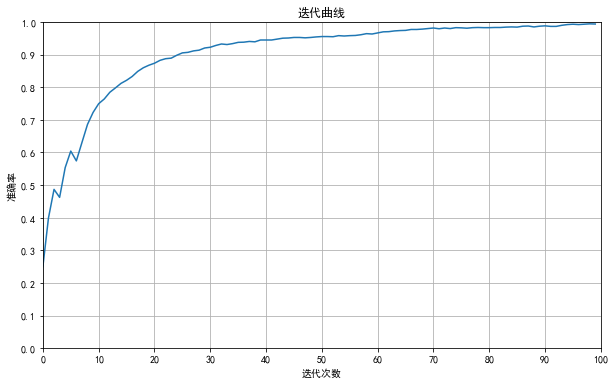

In [83]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']

x = np.linspace(0,99,100)
xi = np.linspace(0,100,11)
yi = np.linspace(0,1,11)

fig, ax = plt.subplots(figsize=(10,6))

ax.set_title('迭代曲线')
ax.set_xlabel('迭代次数')
ax.set_ylabel('准确率')
ax.set_xticks(xi)
ax.set_yticks(yi)
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.grid(True)

ax.plot(x, y)
fig